# Self-Attention

Self-attention is the core mechanism that allows language models to understand relationships between words in text.

1. Each word in a sentence gets converted to a vector (embedding)
2. The model calculates how much attention each word should pay to every other word
3. This creates an "attention matrix" showing these relationships
4. Words get updated based on their connections to other words

For example, in "The cat sat on the mat", when processing "cat", the model pays attention to "sat" to understand what the cat is doing, creating these meaningful connections automatically.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 #hyperparameter

#every single token emits two vector, one for key and one for query
key = nn.Linear(C, head_size, bias=False)   # what information do i contain?
query = nn.Linear(C, head_size, bias=False)  # what am i looking for in other tokens?
value = nn.Linear(C, head_size, bias=False) # what information do i contribute?


# Each query vectors dot product with all key vectors to calculate attention scores
# If a query and key are aligned (similar direction), they'll produce a high score

k = key(x)   # (B, T, 16)- keys for all tokens
q = query(x) # (B, T, 16)- queries for all tokens

wei =  q @ k.transpose(-2, -1)# transpose last two dimension # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# This gives us a BxTxT tensor where each value at position (i,j) 
# represents how much token i should attend to token j
# For each batch, we get a TxT attention matrix (affinity matrix)

tril = torch.tril(torch.ones(T, T))# mask out future positions
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) # normalize scores to sum to 1

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

- There is no notion of space. Attention simply acts over a set of vectors. This is why **we need to positionally encode tokens**.

- Each example across batch dimension is of course processed completely independently and never "talk" to each other

- In an **"encoder"** attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. Useful for example for sentiment analysis. We are **able to see the "future"**

- **This implementation here is called a "decoder"** attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.


- **"Self-attention"** just means that the keys, queries and values are produced from the same source.
- In **"Cross-attention"** the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)



- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below


$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$


This is the standard self-attention formula where:
- $Q$ is the query matrix
- $K$ is the key matrix
- $K^T$ is the transpose of the key matrix
- $V$ is the value matrix
- $d_k$ is the dimensionality of the keys (scaling factor)
- The softmax normalizes the attention weights

In [7]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

____________

# SKIP CONNECTIONS

https://arxiv.org/pdf/1512.03385skip connections

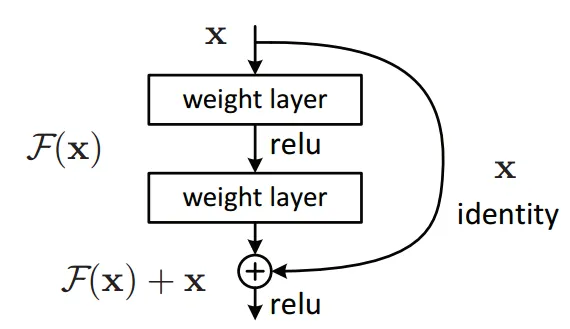

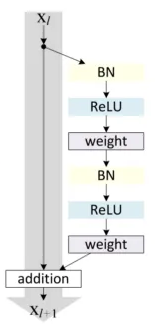

_____________

# LAYER NORM

Batch norm makes sure, across batch dimension, any neuron has unit gaussian distrib (0 mean, a one std)

We dont normalize columns, we normalize rowws!!!

In [ ]:
#class BatchNorm1d:
class LayerNorm1d:  
  def __init__(self, dim, eps=1e-5):
    self.eps = eps
    #self.momentum = momentum
    self.training = True # We eliminate difference between training and testing
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    #self.running_mean = torch.zeros(dim)
    #self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(1, keepdim=True) # batch mean#   We dont normalize columns, we normalize rowws!!!
      xvar = x.var(1, keepdim=True) # batch variance#   We dont normalize columns, we normalize rowws!!!
    #else:
    #  xmean = self.running_mean
    #  xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

____

# Dropout

https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

something you can add before residual connection backs
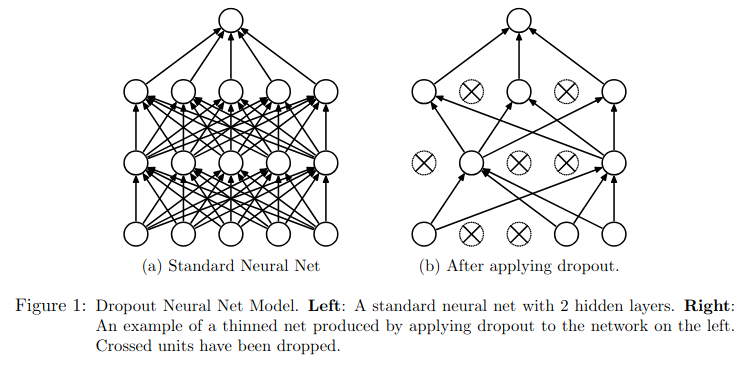

every single forward backward it mask random neurons

if dropout is 0.2--> 20% of calcs a